# Data Visualization
_________________________________________________________________________________

## Introduction

In this tutorial, we'll introduce the **data visualization functions** available in BastionLab and see **how to use them**.

### Technical Requirements

We assume you have:
- Python3.7 or greater *(get the latest version of Python at [https://www.python.org/downloads/](https://www.python.org/downloads/) or with your operating systemâ€™s package manager)*
- [Python Pip](https://pypi.org/project/pip/) (PyPi), the package manager

## Getting Set Up

You'll need to download the **Titanic dataset** as in the quick-tour. The Titanic dataset is one of the most popular datasets used for understanding machine learning and contains information relating to the passengers aboard the Titanic.

You can get the titanic.csv file from: https://www.kaggle.com/code/startupsci/titanic-data-science-solutions/data by creating a free account, or you can run the following lines of code:

In [ ]:
!wget 'https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv'

Next, we'll launch the server using Docker. We specify the environment variable DISABLE_AUTHENTICATION=1 to disable authentication. This is simpy so we can focus on the visualization functions in this tutorial, but is not recommended in production.

In [ ]:
!docker run -it -p 50056:50056 --env DISABLE_AUTHENTICATION=1 -d mithrilsecuritysas/bastionlab:latest

Then, we'll install the necessary dependecies for this notebook - BastionLab and polars:

In [ ]:
! pip install polars
! pip install bastionlab

## Connecting to the Remote Dataset

>*In a typical workflow, the data owner would send a set of keys to the server, so that authorization can be required for all users at the point of connection. **BastionLab offers the authorization feature**, but as it's not the focus of this visualization tutorial, we will not use it. You can refer to the [authorization tutorial]() if you want to set it up.*

We'll connect to remote dataset by create an instance of `Connection()` and supplying the constructor with the host and port of our docker instance.

In [24]:
from bastionlab import Connection

connection = Connection("localhost", 50056)
client = connection.client

Next, we het a Polars DataFrame instance of our csv file using Polars' read_csv function.

We then create a custom policy which disables all data request/query checks. We do this creating a policy where the `safe_zone` parameter to `TrueRule()` to allow all requests. In this case, the `unsafe_handling` parameter can be anything (as there are no unsafe requests), we set it to `Log()` in the following example. Note that this is purely done so that we can focus on demonstrating our visualization functions in this tutorial, but this policy is not suited for production.

Finally, we send the Polars' DataFrame instance to the server using Bastionlab's `polars.send_df()` method which will return a RemoteLazyFrame instance, a reference to the DataFrame uploaded which we will be working with throughout this tutorial.

In [25]:
import polars as pl
from bastionlab.polars.policy import Policy, TrueRule, Log

df = pl.read_csv("titanic.csv")
policy = Policy(safe_zone=TrueRule(), unsafe_handling=Log())
rdf = client.polars.send_df(df, policy=policy)

rdf

FetchableLazyFrame(identifier=1af08460-01c8-4ccc-bea4-0b6a41a620f0)

Since we are using the classic Titanic dataset, let's list the columns to verify we got the right dataset and give you an idea of the data we will be handling in this tutorial.

In [26]:
rdf.columns

['PassengerId',
 'Survived',
 'Pclass',
 'Name',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Ticket',
 'Fare',
 'Cabin',
 'Embarked']

## Histplot
_____________________________________________________________________

Now, let's take a look at the first of our data visualization options, **histplot**.

The histplot function accepts `x` and `y` arguments, which are strings referring to a column name, plus a `bins` integer value, which is set to 10 by default. You must provide either an `x` or `y` argument, the rest is optional. We also accept any `kwargs` arguments accepted by Seaborn's barplot function (This is possible because we call this function internally once we have ran the relevant aggregated query and applied bins to our dataframe.) Accepted options are listed in [the Seaborn documentation](https://seaborn.pydata.org/generated/seaborn.barplot.html).

Let's take a look at a simple example. Here, we create a histogram to show the number of passengers in each age category, with bins of 15.

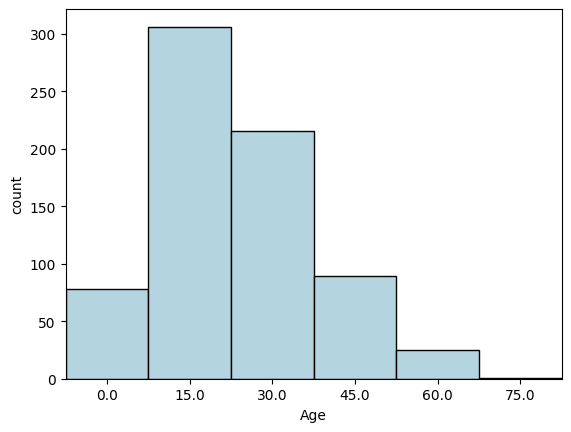

In [27]:
rdf.histplot(x="Age", bins=15)

If we provide an `x` and `y` value, this will internally make use of Seaborn's `heatmap` function and accepts the options listen in [Seaborn's heatmap documentation](https://seaborn.pydata.org/generated/seaborn.heatmap.html).

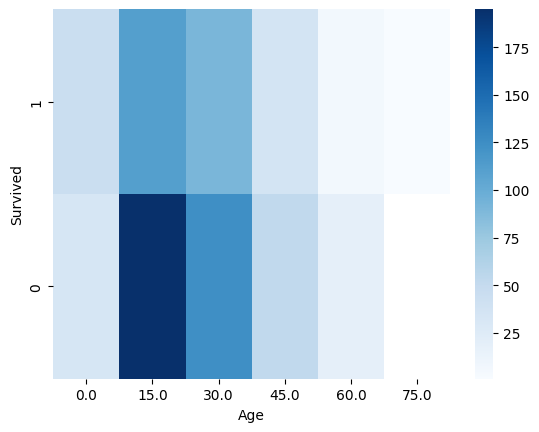

In [28]:
rdf.histplot(x="Age", y="Survived", bins=15)

## Scatterplot
________________________________________________________________________________

The `scatterplot` function plot will display a scatter diagram based on x and y arguments which can be used to look for correlations between x and y columns. Scatterplot requires `x` and `y` string arguments referring to the name of the columns to be used for the x and y axes in the scatterplot.

Scatterplot will first narrow down the RemoteLazyFrame to the necessary columns to make the function call, before calling Seaborn's `scatterplot` function to plot your scattergraph.

This function also accepts the same `optional arguments` as Seaborn's scatterplot function as `kwargs` which you can find [here](https://seaborn.pydata.org/generated/seaborn.scatterplot.html).

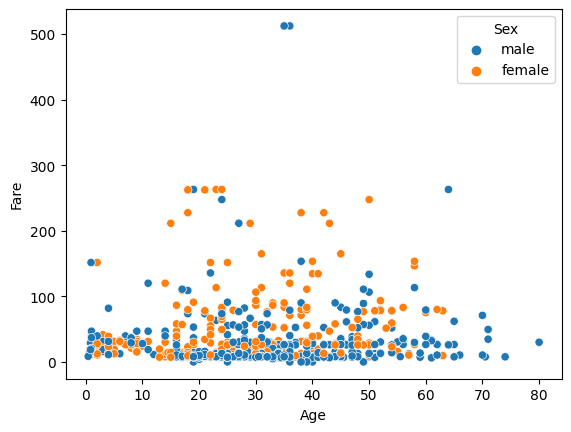

In [29]:
rdf.scatterplot("Age", "Fare", hue="Sex")

## Lineplot
________________________________________________________________________________

The `lineplot` function filters our dataframe down to necessary columns only and then draws a lineplot using Seaborn's `lineplot` function.

Lineplot requires `x` and `y` string arguments that refer to the names of columns to be used for the x and y axes. 

Lineplot also accepts `hue`, `size` and `string` arguments which are the name of the columns to be used as grouping variables which will produce lines with different
colors, widths and dashes and/or markers respectively. Additionally, lineplot accepts a `units` argument which is the name of a column to be used as a grouping variable identifying sampling units- Note that you must also set the `estimator` keyword to None if you wish to use the `units` argument.

Finally, the function also accepts the same `optional arguments` as Seaborn's `lineplot` function as **kwargs which you can find [here]((https://seaborn.pydata.org/generated/seaborn.lineplot.html).

Let's have a look at an example.


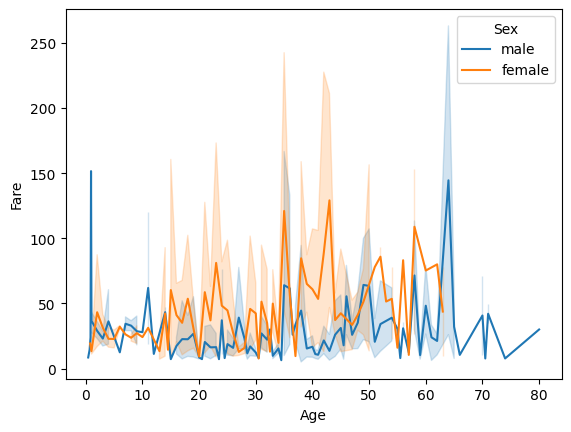

In [30]:
rdf.lineplot(x="Age", y="Fare", hue="Sex")

## Facet Grid Plots
_______________________________________________________________________________________________________________

The facet function lets you create a grid of plots that accepts a `col` and `row` argument. You can then call the `histplot`, `scatterplot` or `curveplot` functions to decide how you want to plot your data in the columns and rows of the grid. 

For example, if you have a Facet with a row value of "Pclass" of class and you call `my_facet.histplot(x="Age", bins=15)`, you will see three histplots: one showing the age of passengers in class 1, one for passengers in class 2 and the final one for class 3.

Before we continue any further, let's see the code for this example:

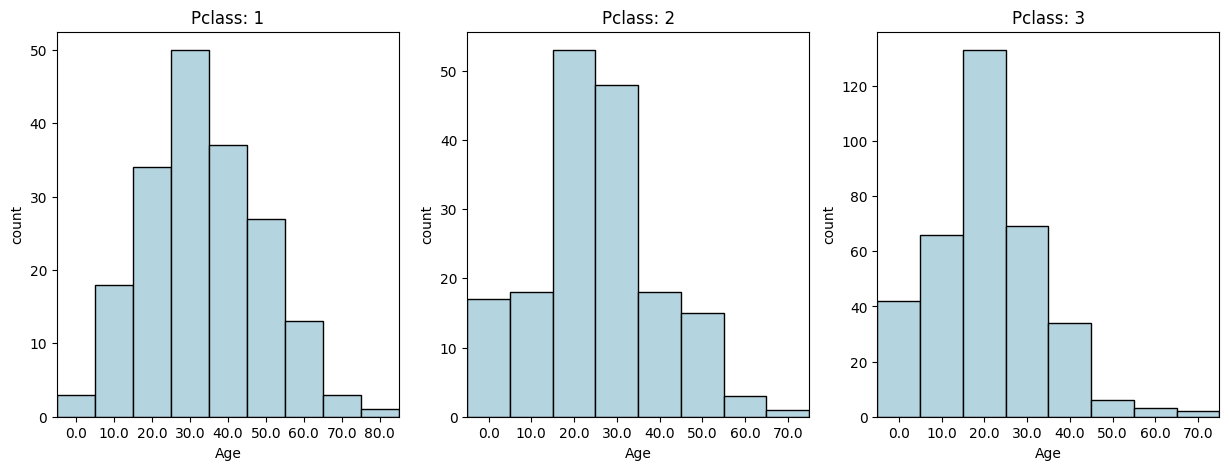

In [31]:
my_facet = rdf.facet(col="Pclass")
my_facet.histplot(x="Age")

Now that we have seen an example with a row, let's add a column! We will also specify the `figsize`, the size of the figure, we want for our grid.

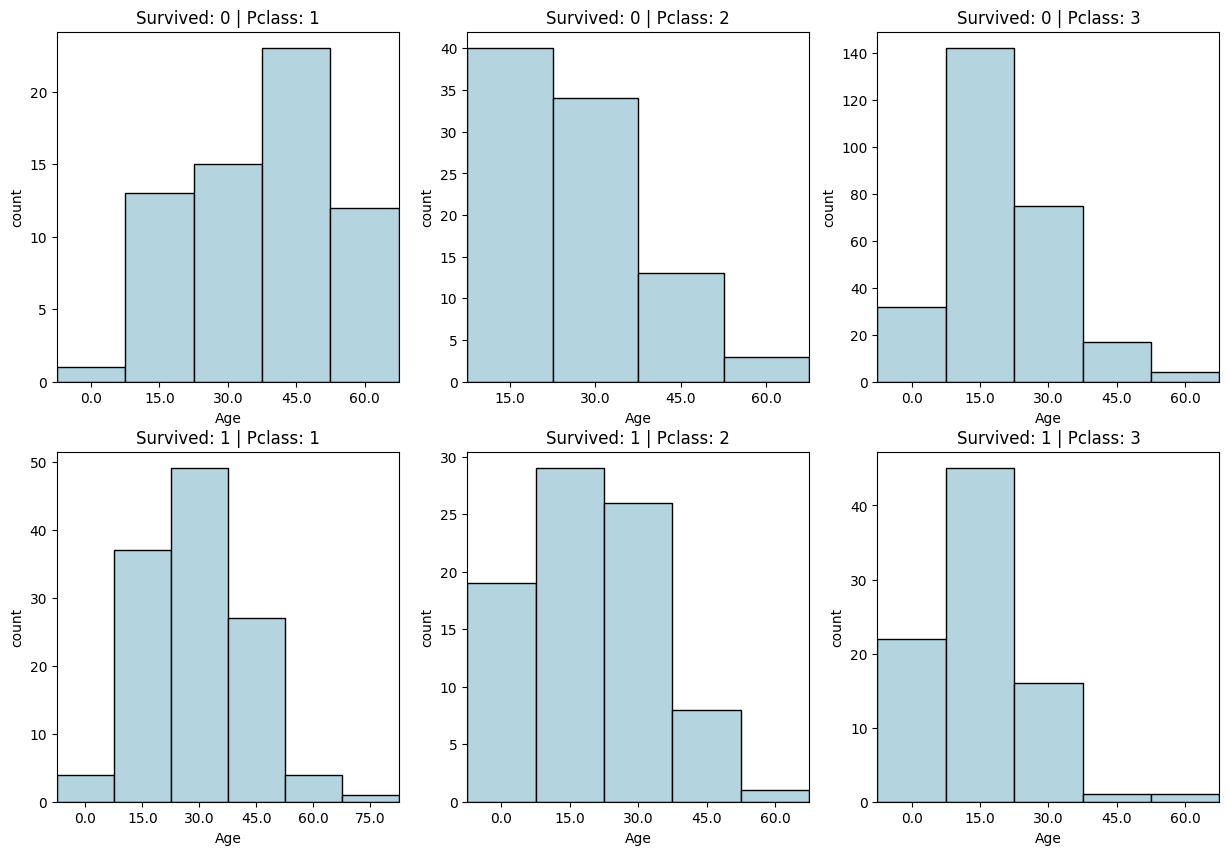

In [32]:
new_facet = rdf.facet(col="Pclass", row="Survived", figsize=(15, 10))
new_facet.histplot(x="Age", bins=15)

As you can see, the grid now splits results into all the possible combinations of the column and row values.

As previously mentioned, this feature works with all the visualization functions. But please note that the `hue`, `size` `string` and `units` keywords are not longer possible for lineplot when using facet. Here's a facet grid with `scatterplot()`, for example:


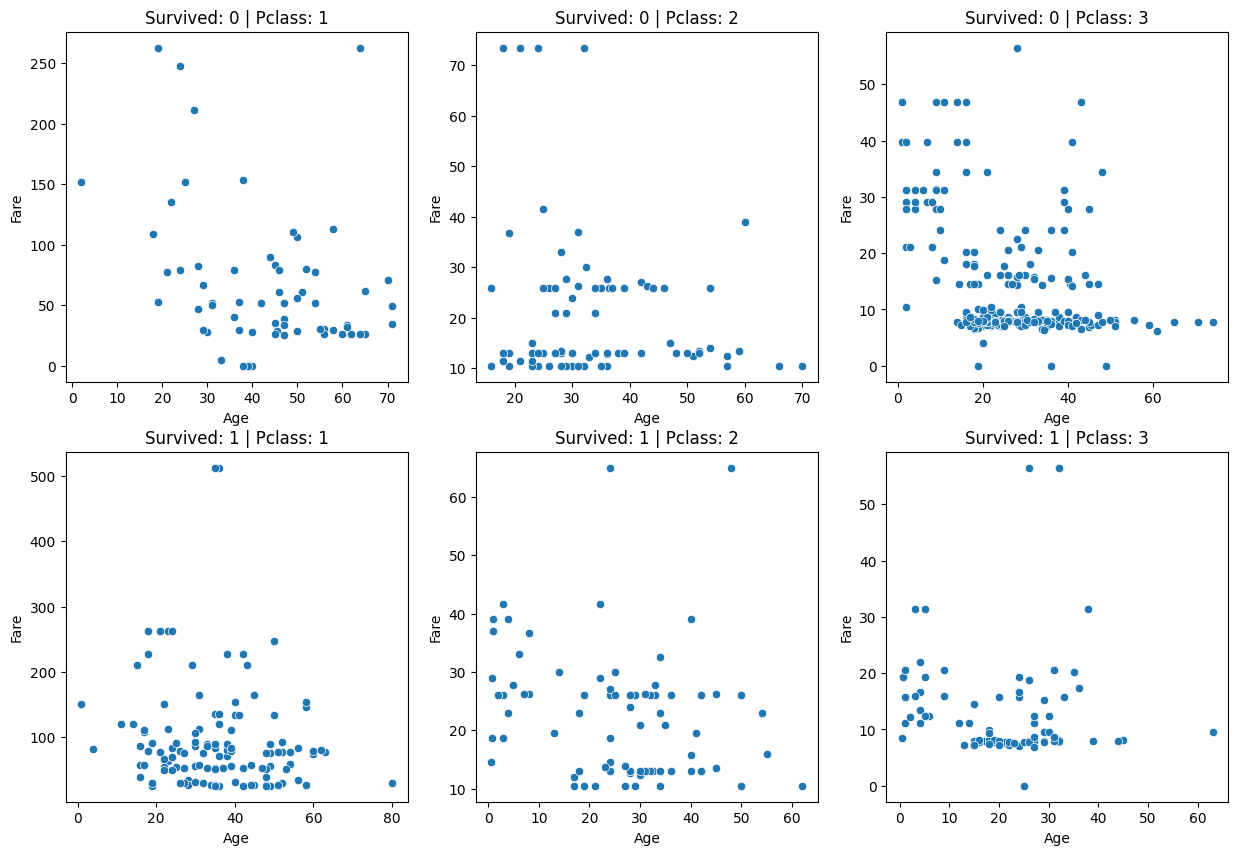

In [33]:
new_facet = rdf.facet(col="Pclass", row="Survived")
new_facet.scatterplot(x="Age", y="Fare")

That's it! So, finally, we will close the connection to the server.

In [34]:
connection.close()